In [146]:
#Becoming a BackProp Ninja

In [147]:
#Before moving into RNN, we need one more thing to better at....

In [148]:
#till now we trained Multi layer perceptron and we are getting pretty good loss. We have good understand of
#its architecture and how it works

#while analyzing the code, we used loss.backward() - that is we are taking a pytorch autograd and we are using it to
#calculate all of our gradients along the way

#let us remove this pytorch backward and write our own backward pass manually on the level of tensors

#it is very uselful to understand the backward for following reasons...
# https://karpathy.medium.com/yes-you-should-understand-backprop-e2f06eab496b
#Backprop is leaky abstraction - it will not work optimally if not understood fully

In [149]:
#in micrograd - we implemented ninja backprop, where each backprop is at individual tensor levels
#but in large neural network, we need to think as a whole

#lets try to implement....

In [150]:
from IPython.display import Image
from IPython.display import display

In [151]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

#### Makemore: becoming a backprop ninja

In [152]:
#copying codes from previous notebooks

In [290]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [291]:
#reading text file and split data and store as list
words = open('names.txt').read().splitlines() 
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [292]:
len(words)

32033

In [293]:
#building vocab of characters and mapping to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [294]:
#buid the dataset
block_size = 3 #context length: how many characters do we take to predict the next one

def build_dataset(words):
    X, Y = [], []
    for w in words:
        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words) #random shuffling
n1 = int(0.8*len(words)) 
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1]) #80% words in to train dataset
Xdev, Ydev = build_dataset(words[n1:n2]) #10% into validation
Xte, Yte = build_dataset(words[n2:]) #rest 10% for test

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [295]:
#utility function that we're going to use later to compare the gradients
#in particular we are going to have the gradients that we estimate manually ourselves and we're going to have gradients
#that pi torch calculates and will check the correctness, assuming ofcourse pytorch is correct
def cmp(s, dt, t): 
    ex = torch.all(dt == t.grad).item() #check if grad calcuated manully and grad from pytorch is same
    app = torch.allclose(dt, t.grad) #check if both are approximately close because of floating point operations
    maxdiff = (dt - t.grad).abs().max().item() #finding difference if any between both manualy and pytorch grad
    print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}') #display all values

In [296]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of MLP

g = torch.Generator().manual_seed(2147483647) #for reproducability
C = torch.randn((vocab_size, n_embd), generator=g)
#Layer1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden, generator=g) * 0.1 #normally b2 as zeor's, no need since we use batch norm
#Layer2
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.1  #making W2 smaller by a factor(0.1, 0.01 etc...)
b2 = torch.randn(vocab_size, generator=g) * 0.1 #normally b2 as zero's
#Batch Norm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0 #batch normalization gain
bnbias = torch.randn((1, n_hidden))*0.1 #batch normalization bias

#Note: I am initializatting many of these parameters in non-standard ways
#because sometimes initalizating with e.g. all zeros could mask an incorrect implementation of the backward pass

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) #no of parameters in total
for p in parameters:
    p.requires_grad = True

12297


In [297]:
batch_size = 32
n = batch_size
#minibactch construct
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix] #bacth X, Y

In [298]:
#forward pass, "chunkated" into smaller steps that are possible to backward one at a time
#reason for forward pass code little longer is ...
#explicitly implemented cross entropy loss function
#broken up the implementation into manageable chunks, so we have lot more intermediate tensors
#and then calculate gradients to back prop the loss from bottom to top.

emb = C[Xb] #embed the batch characters into vectors
embcat = emb.view(emb.shape[0], -1) #concatenate the vectors
#Linear Layer1
hprebn = embcat @ W1 + b1 # hidden layer preactivation
#BatchNorm Layer
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) #note: Bessel's correction (divinding by n-1 not n)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
#Non-Linearity
h = torch.tanh(hpreact) #hidden layer
#Linear Layer2
logits =h @ W2 + b2 #output layer
#cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes #subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1 #if i use (1.0/counts_sum) instead then i cant get backporp to be a bit exact...
probs = counts*counts_sum_inv
logprobs = probs.log() #we will be calculating d_logprobs i.e. derivative of log probs while backpropagating,
#similarly we will be calculating the derivative all these intermediate steps
loss = -logprobs[range(n), Yb].mean()

#Pytorch backward pass
#telling pytorch to retain grads for all these intermediate steps, since we need these values while backpropagation
for p in parameters:
    p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv,  norm_logits, logit_maxes, logits,
          h, hpreact, bnraw, bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani, embcat, emb]:
    t.retain_grad()
loss.backward()
loss

tensor(3.7932, grad_fn=<NegBackward0>)

In [299]:
#Let's begin to implement backprop

In [300]:
#Exerxise1: backprop throught the whole thing manually
#backpropagating through exactly all of the variables as they are defined in the forward pass above, one by one

#we need to understand what should go here to calculate the gradient of loss w.r.t all the elements of logprobs tensor
#dlogprobs =   ??
#now dlogprobs will hold the derivate of the loss w.r.t all the elements of logprobs
#what is inside logprobs ?
#lets find the shape of logprobs
print('logprobs shape:', logprobs.shape)
#32 by 27
#so dlogprobs should also be the size of 32 by 27
#Now how does the log probs influence the loss ?
#loss is negative logprobs indexed  with range of n & Yb and then mean of that...
#quick reminder, Yb is just basically an array of all the correct indices of next char
print('Yb:', Yb)
#so, we are taking the logprobs array of size 32 by 27, and we are going to every single row and in each row,
#we are plucking out the index mentioned in the Yb each accrodingly.
#for ex. logprobs oth row, will pluck out 1st index column value...

logprobs shape: torch.Size([32, 27])
Yb: tensor([ 1, 12,  0,  5,  9, 18,  9, 16,  1,  0,  0,  1,  0,  0, 14, 12,  0,  0,
         0,  8, 25,  5,  0, 20, 19, 15, 12, 22, 22,  2, 21, 18])


In [301]:
logprobs[range(n), Yb]

tensor([-1.6292, -3.8562, -3.7100, -3.4518, -2.9999, -4.8292, -4.9477, -3.6709,
        -3.6610, -4.6134, -3.8363, -4.2130, -4.6107, -3.6460, -4.7727, -3.4062,
        -5.2719, -3.8596, -4.6536, -2.5760, -3.5993, -5.1702, -2.6093, -4.0145,
        -3.6303, -2.8971, -4.7591, -3.2353, -4.6990, -2.7141, -2.7531, -3.0867],
       grad_fn=<IndexBackward0>)

In [302]:
#Therefore logprobs plugs out all those log probabilities of the correct next character in a sequence
print(logprobs[range(n), Yb].shape) #has shape of 32 elements
#now after taking these 32 values, calculating their mean and negative of that becomes loss.

torch.Size([32])


In [303]:
#lets take simple example to understand the numerical form of derivative
#loss = -(a + b + c) / 3 since, mean is diving by total element, in our example 3 variables hence divide by 3
#so what is dloss / da ?
#if simplyfy the loss expression
#loss = (-1/3*a) + (-1/3*b) + (-1/3*c)
#dloss / da = (-1/3) , since b and c will be 0 and a will cancel and left over with (-1/3) i.e in general (-1/n)

In [304]:
#therfore, calcuating dlogprobs
dlogprobs = torch.zeros_like(logprobs) #to initialize zeros as per size of logprobs, 
#instead hardcord manual setting like torch.zeros((32, 27)) 
#now we need to set these values as -1/n for exactly the same location of Yb indexes
dlogprobs[range(n), Yb] = -1.0/n

In [305]:
cmp('logprobs', dlogprobs, logprobs)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0


In [306]:
#notice the logprobs and dlogprobs are exact equallity, also approximate equality and max diff is 0
#basically, our dlogprobs is exact equal to what pytorch calculate the logprobs.grad in its back propagation
#so far, going well

In [307]:
#Lets continue our backprop
#we have logprobs depends on probs through a log function
#so all the elements of probs are being element wise applied log fn
#now if we want dprobs, then remember in micrograd training we had a log node, it takes in probs and creates log probs
#then dprobs will be the local derivative of that individual operation log times the derivative loss w.r.t its output,
#i.e. in this case, it is dlogprobs

#what is the local derivative of probs.log() ?? 
#we know d/dx(log(x)) = 1/x
#in our case x = probs, therefore
dprobs = (1.0 / probs ) * dlogprobs #since applying chain rule i.e w.r.t to all elements till that point

In [308]:
cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0


In [309]:
#notice the derivative of dprobs is exactly similar to that of probs grad calculated by pytorch fn

In [310]:
#notice how dprobs, dprobs = (1.0 / probs ) * dlogprobs works !!
#probs are inverted and then element wise multiplied
#if probs is very very close to 1, i.e. network is predicting the character correctly, then dlogprobs is just passed through
#but if probabilities are incorrectly assigned i.e. correct char getting low probability then
# 1.0 / probs will boost the value
#intutively, dprobs takes low prob assigned and boosting their gradient

In [311]:
#Next up is counts_sum_inv
#lets understand what is happening at this step
#first logits coming out from final output layer, 
#we are finding the maximum in each row using logit_maxes=logits.max(1, keepdim=True).values
#then we are subtracting it from each of logits for the purpose of numerical stability using norm_logits=logits-logit_maxes
#we discussed without this, if logit values are too large, we will end up exponating while applying softmax
#Finally, we are exponentiation of logits to create our counts and then we will take sum of counts and normalize
#so all of the probs sum up to 1

In [312]:
#we need to backpropagate to counts_sum_inv and then to counts
#need to careful because shape of counts_sum_inv and counts are same. why, lets scrutinize !!

In [313]:
counts_sum_inv.shape, counts.shape

(torch.Size([32, 1]), torch.Size([32, 27]))

In [314]:
#counts_sum_inv is (32, 1) but counts is (32, 27)

In [315]:
#so while doing probs = counts * counts_sum_inv, we have an implicit broadcasting that pytorch will do
#it will take column tensor 32 no's  and replicate horizontally 27 times to align these 2 tensors
#so it can do element wise multiplication

In [316]:
#Lets take a toy example and understand this 
#c = a * b but with tensors:
#a[3x3] * b[3x1]
#a11*b1 a12*b1 a13*b1 first element of b is replicated for all the rows of a
#a21*b2 a22*b2 a23*b2 similarly 2nd element of b to a
#a31*b3 a32*b3 a33*b3
#c[3x3]
#how do we backprop the multiplication
#d/db(c) = a  local derivative - since b becomes 1 and we left over with a

In [317]:
#in our case, undoing the multiplication and back propagating through just multiplication itself which is element wise
#is going to be the local derivative, which in this case is d
dcounts_sum_inv = counts * dprobs #because of chain rule, multiply with previous grad dprobs
#this is the derivative or the gradient but w.r.t replicated B, but we dont have a replicaed B
#we just have a single B column 
#so how do we now back propagate thorugh the replication and intutively this b1 is just same variable and its just 
#reused multiple times. take a look at case we encountered in micrograd like
#single node has its output feeding into 2 branches of basically the graph until the last function 
#we're talking about how the correct thing to do in backward pass is we need to sum all the gradients that arrive at any 
#one node, so across these different branches the gradients would sum
#so if a node is used multiple times the gradients for all of its uses, sum during back propagation

#Therefore in our example right thing to do is sum horizontally across all the rows 
dcounts_sum_inv = (counts * dprobs).sum(1, keepdim = True) #keepdim = true to make size same as counts_sum_inv

In [318]:
cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0


In [319]:
#notice the derivatives match exactly

In [320]:
#now, lets also backpropagate into counts which is the other variable here to create probs
dcounts = (counts_sum_inv * dprobs)
#counts_sum_inv is 32 by 1, dprobs is 32 by 27 - broadcast will work fine, no additional summation required
#counts_sum_inv needs to be replicated again to correctly multiply dprobs

In [321]:
#we back propagated from props to counts, but we cant actually validate the derivative counts, reason ?
#counts_sum_inv also depends on counts i.e. we also have a 2nd branch need to be checked
#Because counts_sum_inv back propagates into counts_sum & counts_sum will back propagate to counts
#so, counts is a node that is being used twice
#therefore we need to calculate the 2nd contribution of counts
#lets calculate the derivative of count_sum

In [322]:
#d/dx(1/x) = (1/x**2)
dcounts_sum = -(counts_sum**-2) * dcounts_sum_inv #by chain rule 

In [323]:
cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0


In [324]:
#well we are derivating equally as per pytorch

In [325]:
#next we want to backpropagate through #counts_sum = counts.sum(1, keepdims=True) i.e. counts.sum along the rows

In [326]:
counts.shape, counts_sum.shape

(torch.Size([32, 27]), torch.Size([32, 1]))

In [327]:
#so in this backprop we need to take columns of counts_sum derivatives and transform it into a array of derivatives
#2 -dim array

In [328]:
#eg:
#a11 a12 a13 ---> b1 = (a11 + a12 + a13)
#a21 a22 a23 ---> b2 = (a11 + a22 + a23)
#a31 a32 a33 ---> b3 = (a31 + a32 + a33)
#we are taking 3*3 matrix array and we are summing up the rows into a column tensor b
#now, we have the derivatives of the loss w.r.t b
#but we want to derivative loss with respect to all the 3*3 matrix tensors

In [329]:
#in micrograd, we learnt basicall add '+' operator just routes the gradient from upper to its child equally

In [330]:
dcounts += torch.ones_like(counts) * dcounts_sum #broadcasting counts_sum to counts
#adding because we already calculated dcounts in another branch

In [331]:
cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0


In [332]:
#next counts is element wise exponential of norm logits
#because it is element wise operations, everything is simple 
#local derivative of d/dx(e^x) = e^x
#therefore dnormlogits = (norm_logits.exp())  
#we alerady calculate it and it's inside counts, since counts = norm_logits.exp()
dnorm_logits = counts * dcounts #by chain rule

In [333]:
cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0


In [334]:
#next norm_logits = logits - logit_maxes
#becareful with the shapes - they are not same, & notice internal broadcasting happens

In [335]:
norm_logits.shape, logits.shape, logit_maxes.shape
#there is broacast happening at Minus: logits - logit_maxes

(torch.Size([32, 27]), torch.Size([32, 27]), torch.Size([32, 1]))

In [336]:
#lets understand with e.g.
#basically something like c = a - b
#c11 c12 c13 = a11 a12 a13   b1
#c21 c22 c23 = a21 a22 a23 - b2
#c31 c32 c33 = a31 a32 a33   b3

#so e.g. tensor c32 = a32 - b3
#every element of c is just corresponding element of a minus associate b

#notice how b is broadcasted 

#the derivatives of every one of C's with respect to their inputs are one for the corresponding a and 
#negative one for the corresponding b
#the derivatives on the c will flow equally to the corresponding a's and then also to the corresponding b's but then
#in addition to that b's are broadcast,so we'll have to do the additional sum just like before
#ofcourse derivatives for b's will undergo a minus because the local derivative here is -1 i.e. dc/db = -1

In [337]:
#dlogits will be exactly copyinng the derivative of dnorm_logits
dlogits = dnorm_logits.clone() #just taking copy
#dlogit_mazes will be negative of dnorm_logits
dlogit_maxes = -(dnorm_logits).sum(1, keepdim=True) #logit_maxes is column
#doing sum and keepdim = True because this will be broadcasted along column

In [338]:
#notice dlogits calculated above is not final, because
#not only we get gradients inot logits but logit_maxes is a function of logits and ther's a 2nd branch into logits
#we will comeback to logits later

In [339]:
cmp('logits', dlogits, logits)
#notice the difference in logits, as still need to accomodate the 2nd brach for logits

logits          | exact: False | approximate: True  | maxdiff: 4.889443516731262e-09


In [340]:
#only dlogit_maxes id the final derivative. so lets compare
cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0


In [341]:
#before we move one, lets understand about logit_maxes and especially their gradients
#we are doing the step norm_logits = logits - logit_maxes for numerical stability of the softmax we are implementing
#we know, taking any tensor matrix and we add/subtract equally to all the elements of tensor then the value of probs
#will be unchanged; we are not changing the softmax
#only thing that this will do is making sure exp() not overflow
#reason we are using a max is because then we are guaranteed that each row of the logit the highest no is 0
#so, exp() will be safe
#this step has repercussions
#if it is the case that changing logit_maxes does not change the probs and therefore there's not change in loss then
#the gradient on logit_maxes should be zero
#indeex checking logit_maxes, values are very very small

In [342]:
dlogit_maxes

tensor([[ 1.2806e-09],
        [ 2.3283e-10],
        [-2.3283e-09],
        [ 4.8894e-09],
        [ 4.1910e-09],
        [ 6.9849e-10],
        [ 3.0268e-09],
        [-1.1642e-09],
        [-1.3970e-09],
        [ 2.3283e-10],
        [-4.1910e-09],
        [-2.5611e-09],
        [ 9.3132e-10],
        [ 9.3132e-10],
        [-1.8626e-09],
        [-9.3132e-10],
        [-0.0000e+00],
        [ 3.6089e-09],
        [-9.3132e-10],
        [-1.1642e-09],
        [ 2.3283e-10],
        [ 2.3283e-10],
        [-4.8894e-09],
        [-4.6566e-10],
        [-3.7253e-09],
        [-0.0000e+00],
        [ 4.6566e-10],
        [ 1.8626e-09],
        [-4.8894e-09],
        [-1.1642e-09],
        [-0.0000e+00],
        [ 1.8626e-09]], grad_fn=<NegBackward0>)

In [343]:
#it feels wierd to back propagate through this branch honestly
#but pytorch implementation of this cross entropy, we'll block all these elements  and we're not doing backpropagate 
#piece by piece, we will assume that derivate through logit_maxes is exactly zero i.e. skipping this branch
#values of these branch is not matter w.r.t final loss

In [344]:
#lets continue to backpropagate through the code # logit_maxes = logits.max(1, keepdim=True).values
#here we took logits and we took the max along all the rows and then we looked at its values
#lets see how it looks in pytorch

In [345]:
logits.max(1, keepdim=True)

torch.return_types.max(
values=tensor([[2.0854],
        [1.0133],
        [1.7638],
        [1.1650],
        [1.6235],
        [1.6857],
        [1.6086],
        [0.7135],
        [1.2535],
        [1.8243],
        [2.4218],
        [1.9293],
        [2.1878],
        [2.0516],
        [2.0386],
        [2.3344],
        [2.0810],
        [2.7363],
        [2.8291],
        [0.7135],
        [2.1842],
        [1.2363],
        [1.3116],
        [1.4915],
        [1.8405],
        [1.0793],
        [2.1424],
        [0.8811],
        [1.4251],
        [0.7135],
        [1.1616],
        [0.7135]], grad_fn=<MaxBackward0>),
indices=tensor([[ 1],
        [26],
        [15],
        [25],
        [ 6],
        [11],
        [14],
        [11],
        [22],
        [ 4],
        [14],
        [24],
        [ 5],
        [ 5],
        [24],
        [ 9],
        [10],
        [ 5],
        [ 5],
        [11],
        [ 9],
        [20],
        [19],
        [13],
        [24],
        [

In [346]:
#max returns both the values and also the indices at which those max values are found
#in forward pass we only used values because thats what we need
#but in backward pass its extremely useful to know about where those max values occur and we have the indices of occurence
#this will help us to do back propagation

In [347]:
logits.shape

torch.Size([32, 27])

In [348]:
#logits shape is 32 * 27
# each row we find the max value and that values plucked out into logit_maxes
#intutively, the derivative flowing through here then should be 1 i.e. derivative is 1 for appropriate entry of max value
#that was plucked out times the global derivative of logit_maxes

In [349]:
#what we're doing here is we need to take the dlogit_maxes and we need to scatter it to the correct positions in 
#these logits from where the maximum values came !!
#we leverage torch.one hot and then taking the max function - index values and telling dim of each should be 27

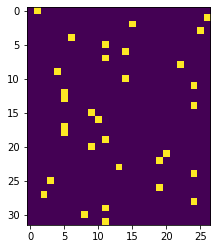

In [350]:
plt.imshow(F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]))
#really just an array of where the maxes came from in each row that element is 1 and all others are 0

In [351]:
dlogit_maxes.shape
#32 * 1 which will broadcast to 1-hot vector of 32 * 27
#element wise multiplication and ensure grad's are routed to whichever 1 bits is turned

torch.Size([32, 1])

In [352]:
dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes
# + because we already calculated logits and adding 2nd branch

In [353]:
cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0


In [354]:
#now logits gradients match with pytorch

In [355]:
#Let's continue with next logits =h @ W2 + b2 : matrix multiplication and bias offset
#analyze the shape

In [356]:
dlogits.shape, h.shape, W2.shape, b2.shape

(torch.Size([32, 27]),
 torch.Size([32, 200]),
 torch.Size([200, 27]),
 torch.Size([27]))

In [357]:
#logits have shape of 32 * 27, h is 32 * 200, these are 200 dimensional hidden states, 
#W matrix projects those 200 dimensional vectors into 27 dimensions  and finally 27 dim offset from bias b2 - 1 dim vector
#note that + actually broadcasts because h * W2 - will give 32 * 27 and this + b2  is a 27 dim vector 
#now in the rules of broadcasting what's going to happen with the bias vector is that this 1 dim vector of 27 will
#get aligned with a padded dimension of one on the left and it will basically become a row vector and then it will get
#replicated vertically 32 times to make it 32 * 27 and there's an element wise multiply

In [358]:
#Question is how do we backpropagate from logits to the hidden states, the weight matrix and the bias b2 ?
#nothing complex, if we know the first principles and derive it easily yourself
#best way is to take a specific small example, fully write out and then process of analyzing how that individual
#small example works, you will understand the broader pattern, finally generalize for broader area

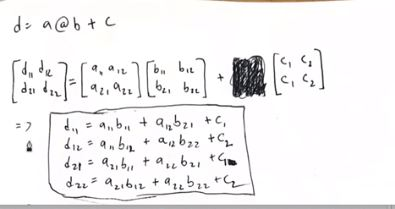

In [359]:
x = Image(filename=r"C:\Users\welcome\Desktop\AndrejKarpathy\derive1.JPG")
y = Image(filename=r"C:\Users\welcome\Desktop\AndrejKarpathy\derive2.JPG")
z = Image(filename=r"C:\Users\welcome\Desktop\AndrejKarpathy\derive3.JPG")
display(x)

In [360]:
#d = a * b + c where a & b as 2 * 2 matrix and c is 1 dim vector of 2 indices
#notice how c vector is broadcasted into row vector and helps with addition
#now how d vector is formed using matrix multiplication
#for e.g. d11 - result of dot product between first row of a and first column of b i.e "a11*b11 + a12*b12 + c1"
#from micrograd, we know how to diffeentiate multiplies and adds

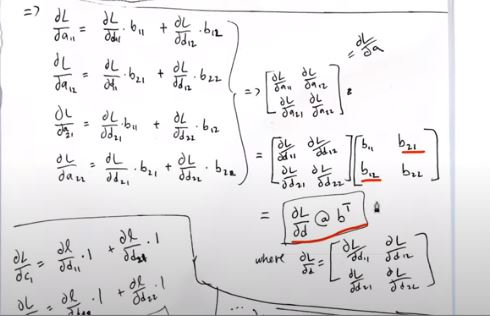

In [361]:
display(y)

In [362]:
#say lets find derivative of loss w.r.t a11 
#notice a11 occurs twice in matrix multiplication i.e. a11 influences d11 and d12
#dl/da11 = dl/d11.b11 + dl/d12.b12 ; since a11 is contributing to both of those chains running in parallel, we need to add
#expanding to all ther elements and analyzing the pattern,
#turns out to be dl/da = "dl/dd matrix multiplied  with b transpose"

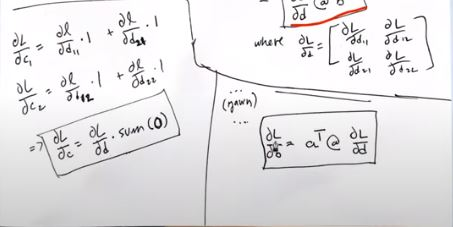

In [363]:
display(z)

In [364]:
#similarly, if we differentiate the d matrix w.r.t b, then we will get
#dl/db = "a transponse matrix multipled with dl/dd"

In [365]:
#also, dl/dc = dl/dd * sum(0) i.e. derivatives of D mutltiplied to sum across the columns of  c

In [366]:
#long term short, backward pass for matrix multiply is a matrix multiply...

In [367]:
dlogits.shape, h.shape, W2.shape, b2.shape

(torch.Size([32, 27]),
 torch.Size([32, 200]),
 torch.Size([200, 27]),
 torch.Size([27]))

In [368]:
#Secret to remember for matrix multiplication derivative is - the dimensions has to workout
#say we need to find dh - what should the h be ? - we know shape of dh should be same as h
#shape of h is 32 * 200; 
#other thing we know is db must be some kind of matrix multiplication of the logits with w2
#dlogits shape is 32 * 27; w2 is 200 * 27; now, there is only one way to make the shape work out in this case
#h needs to be 32 * 27, only way to do this take dlogits and matrix multiply it with Transponse of W2

In [369]:
dh = dlogits @ W2.T
dW2 = h.T @ dlogits
db2 = dlogits.sum(0)

In [370]:
cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0


In [371]:
#next up, we have derivative for the h and we need to backpropagate through tanh into hpreact: h = torch.tanh(hpreact)

In [372]:
#if a = tanh(z) then  da/dz = = 1 - a^2 where a is the output of tanh not the input of tanh
dhpreact = (1.0 - h**2) * dh #chain rule,so multiplied with dh
#output of tanh for this is h, hence h^2

In [373]:
cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: True  | approximate: True  | maxdiff: 0.0


In [374]:
#Next we have : hpreact = bngain * bnraw + bnbias, we need to backpropagate into the  bngain, bnraw and bnbias
#here these are batch norm parameters... i.e it takes bnraw - exact unit guassian and then scale & shift it
#Note: @ & * are different proecss. @ is multiplicaion of rows and columns, whereas * is element wise multiplication
#Also, carefully analyizing broadcasting is happening

In [375]:
hpreact.shape, bngain.shape, bnraw.shape, bnbias.shape

(torch.Size([32, 200]),
 torch.Size([1, 200]),
 torch.Size([32, 200]),
 torch.Size([1, 200]))

In [376]:
#bngain & bnbias are shape of 1 * 200, but hpreact and bnraw are 32 * 200 
#need to careful about the size when backpropagating

In [377]:
#start with bngain...
#we know whenever c = a*b and local derivative of dc/da = b, therfore ....
#dbngain = bnraw * dhpreact : because of chain rule
#but bngain is of size 1 * 200, but bnraw & dhpreact are size of 32 * 200
#correct way to do is that, bngain vector of 200 is replicated vertically in this operation, therfore we need to sum
#Also need to careful because to make size of 1 * 200, so keepdim = true
dbngain = (bnraw * dhpreact).sum(0, keepdim=True)

In [378]:
#similarly for bnraw
dbnraw = (bngain * dhpreact) #no need for sum, because broadcast happens

In [379]:
#since bias is added, gradient will simply flow into the biases and add up, because these are just offsets
#need to sum along right direction
dbnbias = dhpreact.sum(0, keepdim=True)

In [380]:
cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnraw', dbnraw, bnraw)
cmp('bnbias', dbnbias, bnbias)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: True  | approximate: True  | maxdiff: 0.0
bngain          | exact: True  | approximate: True  | maxdiff: 0.0
bnraw           | exact: True  | approximate: True  | maxdiff: 0.0
bnbias          | exact: True  | approximate: True  | maxdiff:

In [381]:
#now we are getting into batch norm layer.. bngain & bnbias are parameters , so backprop ends
#bnraw = bndiff * bnvar_inv : is output of standardization
#we have broken down broken up the batch norm into manageable piece so we can backpropagate throgh each line individually
#basically what happening is ....
#bnmeani is the sum; bndiff is x - Mu; bndiff is (x - Mu)^2
#bnvar is the variance i.e. sigma^2; basically it is the sum of squares 
#notice in variance, we divide by total n, but in our logice we divided by (n-1) - bassel's correction, we'' get back later
#bnvar_inv is basically variace + epsilon and their square root; -ve becaise of inverse in formula
#bnraw is xhat : equal to the bndiff multiplied by bnvar_inv

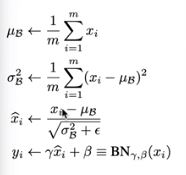

In [382]:
z = Image(filename=r"C:\Users\welcome\Desktop\AndrejKarpathy\derive4.JPG")
display(z)

In [383]:
#lets backpropagate through bndiff & bnvar_inv: bnraw = bndiff * bnvar_inv
#Lets find the shapes

In [389]:
bnraw.shape, bndiff.shape,  bnvar_inv.shape

(torch.Size([32, 200]), torch.Size([32, 200]), torch.Size([1, 200]))

In [390]:
#bnvar_inv has a shape of 1*200, so there is a broadcasting happening
#but the equation bnraw = bndiff * bnvar_inv is element wise multiplication, hence easy to backpropagate

In [391]:
dbndiff = bnvar_inv * dbnraw
dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
#but ensure broadcast will work, particularly the size of dbnvar_inv should be 1*200, hence summing

In [392]:
cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnraw', dbnraw, bnraw)
cmp('bnbias', dbnbias, bnbias)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bndiff', dbndiff, bndiff)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: True  | approximate: True  | maxdiff: 0.0
bngain          | exact: True  | approximate: True  | maxdiff: 0.0
bnraw           | exact: True  | approximate: True  | maxdiff: 0.0
bnbias          | exact: True  | approximate: True  | maxdiff:

In [393]:
#Notice, bndiff gradient is not matching, why?
#bndiff is used in other branches, hence we need to calculate gradient for that branch also for correct match

In [394]:
#Next find gradient for : bnvar_inv = (bnvar + 1e-5)**-0.5 
dbnvar = (-0.5 *  (bnvar + 1e-5) ** (-1.5) * 1 ) * dbnvar_inv  #i.e d/dx(x^n) = n (x^n-1)

In [395]:
cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnraw', dbnraw, bnraw)
cmp('bnbias', dbnbias, bnbias)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: True  | approximate: True  | maxdiff: 0.0
bngain          | exact: True  | approximate: True  | maxdiff: 0.0
bnraw           | exact: True  | approximate: True  | maxdiff: 0.0
bnbias          | exact: True  | approximate: True  | maxdiff:

In [396]:
#bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) #note: Bessel's correction (divinding by n-1 not n)
#before proceeding with this, lets understand about bessel's correction divided by n-1 instead n ??
#In original paper, it was divided by n instead n-1
#as we know, there are 2 types of estimating a statistics i.e. for population or samples
#1/n - is biased estimate, 1/n-1 is unbiased estimate
#notice in paper, while training they used biased estimate & in inference they used unbiased estimate
#since mini batches are samples from large population, advisable to use sample static....

In [397]:
#Proceeding, lets  scrutinize the shapes first as always...
bnvar.shape, bndiff2.shape
#notice the shapes mismatch, hence we used sum function at oth axis to squash the first dim of the shapes
#allowing for broadcasting

(torch.Size([1, 200]), torch.Size([32, 200]))

In [398]:
#anytime if u notice a sum in the forward pass that turns into a replication or broadcasting in the backward pass
#along the same dimension
#conversely when we have a replication or a broadcasting in the backward pass that indicates a variable reuse, that turns
#into a sum over the exact same dim

In [399]:
#once we know the shape, lets look at toy example to understand the dependencies go in mathematical formula
#a11 a12
#a21 a22
#[b1 b2]
#b1 = 1/(n-1) * (a11 + a21)
#b2 = 1/(n-1) * (a21 + a22)

#here we have 2 dim array, which we are scaling by a constant and we are summing vertically over the columns
#we will get row vector b1 & b2
#we now have derivatives of b1 & b2, backpropagate into a's

In [400]:
dbndiff2 = (1.0/(n-1)) * torch.ones_like(bndiff2) * dbnvar #creating a large array of 2-dim ones and then scale it

In [401]:
bnvar.shape, bndiff2.shape

(torch.Size([1, 200]), torch.Size([32, 200]))

In [402]:
#broadcast happens to match dim

In [403]:
cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnraw', dbnraw, bnraw)
cmp('bnbias', dbnbias, bnbias)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: True  | approximate: True  | maxdiff: 0.0
bngain          | exact: True  | approximate: True  | maxdiff: 0.0
bnraw           | exact: True  | approximate: True  | maxdiff: 0.0
bnbias          | exact: True  | approximate: True  | maxdiff:

In [261]:
#next, bndiff2 = bndiff**2
dbndiff = (2 * bndiff) * dbndiff2 #notice not added previous dbndiff, hence output is wrong

In [118]:
cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnraw', dbnraw, bnraw)
cmp('bnbias', dbnbias, bnbias)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)
cmp('bndiff', dbndiff, bndiff)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: True  | approximate: True  | maxdiff: 0.0
bngain          | exact: True  | approximate: True  | maxdiff: 0.0
bnraw           | exact: True  | approximate: True  | maxdiff: 0.0
bnbias          | exact: True  | approximate: True  | maxdiff:

In [404]:
dbndiff += (2 * bndiff) * dbndiff2

In [405]:
cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnraw', dbnraw, bnraw)
cmp('bnbias', dbnbias, bnbias)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)
cmp('bndiff', dbndiff, bndiff)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: True  | approximate: True  | maxdiff: 0.0
bngain          | exact: True  | approximate: True  | maxdiff: 0.0
bnraw           | exact: True  | approximate: True  | maxdiff: 0.0
bnbias          | exact: True  | approximate: True  | maxdiff:

In [406]:
#next : bndiff = hprebn - bnmeani
#checking the shapes

In [407]:
bndiff.shape, hprebn.shape, bnmeani.shape
#bnmeani is actually broadcasting

(torch.Size([32, 200]), torch.Size([32, 200]), torch.Size([1, 200]))

In [408]:
#Now we know, a broadcasting in forward pass is variable reuse, therefore it will sum in the backward pass

In [409]:
dhprebn = dbndiff.clone() 
#since bndiff & bprebn are same shape, the local derivative for each one of the elements in
#dbndiff is just one for the corresponding element in hpbren
#basically these are copies i.e. just a variable assignment
dbnmeani = (-torch.ones_like(bndiff) * dbndiff).sum(0)

In [410]:
cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnraw', dbnraw, bnraw)
cmp('bnbias', dbnbias, bnbias)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)
cmp('bndiff', dbndiff, bndiff)
cmp('hprebn', dhprebn, hprebn)
cmp('bnmeani', dbnmeani, bnmeani)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: True  | approximate: True  | maxdiff: 0.0
bngain          | exact: True  | approximate: True  | maxdiff: 0.0
bnraw           | exact: True  | approximate: True  | maxdiff: 0.0
bnbias          | exact: True  | approximate: True  | maxdiff:

In [411]:
#hprebn has 2nd branch, hence we need to calculate its gradient for correct results

In [412]:
#Next, backpropagate step : bnmeani = 1/n*hprebn.sum(0, keepdim=True)
#here there is sum along 0th dimension, this will change into broadcasting in backward pass now
#this is very similar to step bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True)

In [413]:
dhprebn += (1.0/n) *  (torch.ones_like(hprebn) * dbnmeani)
#gradient dbnmeani will be scaled over 1/n & it's going to flow across all the columns and deposit into hprebn

In [414]:
cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnraw', dbnraw, bnraw)
cmp('bnbias', dbnbias, bnbias)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)
cmp('bndiff', dbndiff, bndiff)
cmp('hprebn', dhprebn, hprebn)
cmp('bnmeani', dbnmeani, bnmeani)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: True  | approximate: True  | maxdiff: 0.0
bngain          | exact: True  | approximate: True  | maxdiff: 0.0
bnraw           | exact: True  | approximate: True  | maxdiff: 0.0
bnbias          | exact: True  | approximate: True  | maxdiff:

In [415]:
#now hprebn gradient matching with pytorch

In [416]:
#Next backpropagate through linear layer: hprebn = embcat @ W1 + b1
#finding the shapes 1st

In [417]:
hprebn.shape, embcat.shape, W1.shape, b1.shape

(torch.Size([32, 200]),
 torch.Size([32, 30]),
 torch.Size([30, 200]),
 torch.Size([200]))

In [418]:
#backpropagating through linear layer is easy, just by matching the shape

In [419]:
dembcat = dhprebn @ W1.T #matrix multiplication of dhprebn with W1 and one transpose thrown in there
#make dembcat 32 * 30 = dhprebn 32 * 200 multiply with W1 30 * 200 transpose

In [420]:
dW1 = embcat.T @ dhprebn #shape should be 30 * 200

In [421]:
db1 = dhprebn.sum(0) #summing along 0, so we eleminate 32 dim and have only 200 

In [422]:
cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnraw', dbnraw, bnraw)
cmp('bnbias', dbnbias, bnbias)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)
cmp('bndiff', dbndiff, bndiff)
cmp('hprebn', dhprebn, hprebn)
cmp('bnmeani', dbnmeani, bnmeani)
cmp('embcat', dembcat, embcat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: True  | approximate: True  | maxdiff: 0.0
bngain          | exact: True  | approximate: True  | maxdiff: 0.0
bnraw           | exact: True  | approximate: True  | maxdiff: 0.0
bnbias          | exact: True  | approximate: True  | maxdiff:

In [423]:
#now we have derivative for embcat, we want to back propagate into emb view : embcat = emb.view(emb.shape[0], -1)

In [424]:
embcat.shape, emb.shape

(torch.Size([32, 30]), torch.Size([32, 3, 10]))

In [425]:
#notice the shapes, emb has the concatenation of 3 - 10 dim vectors

In [426]:
demb = dembcat.view(emb.shape) #just unpacking

In [427]:
cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnraw', dbnraw, bnraw)
cmp('bnbias', dbnbias, bnbias)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)
cmp('bndiff', dbndiff, bndiff)
cmp('hprebn', dhprebn, hprebn)
cmp('bnmeani', dbnmeani, bnmeani)
cmp('embcat', dembcat, embcat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)
cmp('emb', demb, emb)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: True  | approximate: True  | maxdiff: 0.0
bngain          | exact: True  | approximate: True  | maxdiff: 0.0
bnraw           | exact: True  | approximate: True  | maxdiff: 0.0
bnbias          | exact: True  | approximate: True  | maxdiff:

In [428]:
#Now we are in final line, only line to backpropagate is emb = C[Xb]
#lets look at the shape

In [429]:
emb.shape, C.shape, Xb.shape

(torch.Size([32, 3, 10]), torch.Size([27, 10]), torch.Size([32, 3]))

In [430]:
#emb has shpae of 32 examples * 3 characters * 10 dimensional embedding
#this was achieved by using lookup table C which has 27 Possible characters * 10 dimensional
#we looked up at the rows that were specified inside the tensor Xb which is 32 for each example giving index * 3

In [431]:
Xb[:5] #printing 1st  chars

tensor([[ 4,  5, 23],
        [18, 14, 21],
        [12, 12, 25],
        [ 5,  5,  3],
        [ 5, 12,  5]])

In [432]:
#row 1 indicates 4th char, 5th char & 23 char --> predict the next char in the sequence
#basically there are integers inside Xb and each of these integers specifying which row of C we want to pluck out 
#and then we arange those rows that we've plucked out into 32 * 3 * 10 tensors and  we just package them into the tensor

In [433]:
#now, we have demb - gradients of plucked out rows, we just need to route this gradient backwards through this assignment
#So we need to find which row of C that every one of these 10 dim embeddings comes from & then we need to deposit them
#into DC i.e. just undo the indexing 

In [434]:
dC = torch.zeros_like(C) #intialize 27 * 10 with all zeros
for k in range(Xb.shape[0]): #iterating over all the rows & columns of Xb
    for j in range(Xb.shape[1]):
        ix = Xb[k, j] #getting the index of current char
        #in forward pass we took row of C at index and we deposited it into emb at K of J
        #now we need to go back and we just need to route demb
        dC[ix] += demb[k, j] #adding because of multiple occurance of characters in each input

In [435]:
cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnraw', dbnraw, bnraw)
cmp('bnbias', dbnbias, bnbias)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)
cmp('bndiff', dbndiff, bndiff)
cmp('hprebn', dhprebn, hprebn)
cmp('bnmeani', dbnmeani, bnmeani)
cmp('embcat', dembcat, embcat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)
cmp('emb', demb, emb)
cmp('C', dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: True  | approximate: True  | maxdiff: 0.0
bngain          | exact: True  | approximate: True  | maxdiff: 0.0
bnraw           | exact: True  | approximate: True  | maxdiff: 0.0
bnbias          | exact: True  | approximate: True  | maxdiff:

In [436]:
#Exercise 2: backprop through cross entropy but all in one go
#to complete this challenge look at the mathematical expression of the loss,
#take the derivative, simplify the expression, and nust write it out

#forwar pass

#before:
#logit_maxes = logits.max(1, keepdim=True).values
#norm_logits = logits - logit_maxes #subtract max for numerical stability
#counts = norm_logits.exp()
#counts_sum = counts.sum(1, keepdim=True)
#counts_sum_inv = counts_sum**-1 #if I use (1.0/ counts_sum) instead then i cant get backprop to be bit exact
#probs = count * counts_sum_inv
#logprobs = probs.log()
#loss = -logprobs[range(n), Yb].mean()

#now:

loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

3.793226718902588 diff: 0.0


In [438]:
#now we have come to Exercise2
#in exercise 1 we broken loss function into multiple lines and backpropagated, but in practical we leverage torch function
#but mathematically if we take derivative of loss function and solver it is much simple to backpropagate
#in pytorch everything is simplified using single call F.cross_entropy
#so wanted , using single operation or call, need to backpropagate the loss function

In [ ]:
#we can derive what exactly the mathematical expression of loss and differentiate with respect to logits
#we logits - applying softmax will give - probabilities
#we are using the identity of correct next char to pluck out the row of probabilities 
#take negative log of it , to get out negative log probability 
#average up all to get loss value

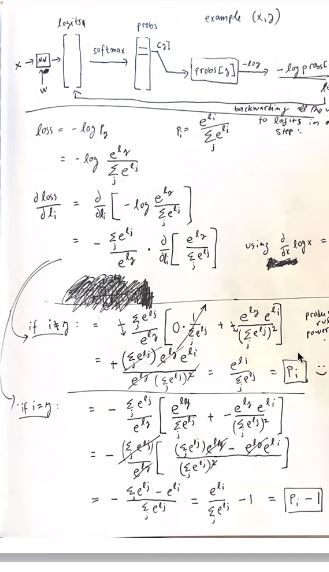

In [437]:
x = Image(filename=r"C:\Users\welcome\Desktop\AndrejKarpathy\cross.JPG")
display(x)

In [ ]:
#expression is simplified based on output matching or not i.e. ith index we are looking whether equal to label or not
#we end up with Pi or Pi -1 where Pi is vector of probabilities after a softmax 
#so in any case we just need to calculate the softmax function and then in correct dimension we need to subtract 1
#we need to apply this for whole batch & the loss for a batch is the average loss over all the examples

In [439]:
dlogits = F.softmax(logits, 1) #applying softmax on the logits as per above derivative along the axis 1 i.e rows
dlogits[range(n), Yb] -= 1 #at correct position, we subtract 1
dlogits /= n #finally, average loss so divide by n

In [440]:
cmp('logits', dlogits, logits)

logits          | exact: False | approximate: True  | maxdiff: 4.889443516731262e-09


In [441]:
#max diff is very small, very small difference, because of floating point differences

In [442]:
#before we move, lets take a look at dlogits and understand intutively

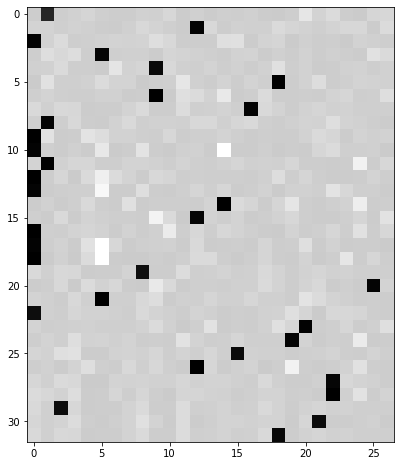

In [444]:
plt.figure(figsize=(8,8))
plt.imshow(dlogits.detach(), cmap='gray') #taking the logits & visualizing it
#notice we have batch of 32 examples of 27 characters
#dlogits is the probabilities that the probability matrix in forward pass
#black spots are position of correct indices where we subtracted a 1

In [445]:
#lets take a look at 1st row of dlogits
F.softmax(logits, 1)[0]

tensor([0.0111, 0.1961, 0.0171, 0.0336, 0.0512, 0.0206, 0.0104, 0.0123, 0.0303,
        0.0277, 0.0613, 0.0072, 0.0262, 0.0072, 0.0205, 0.0190, 0.0279, 0.0058,
        0.0023, 0.0159, 0.1343, 0.0410, 0.0817, 0.0144, 0.0043, 0.0574, 0.0633],
       grad_fn=<SelectBackward0>)

In [446]:
dlogits[0] * n

tensor([ 0.0111, -0.8039,  0.0171,  0.0336,  0.0512,  0.0206,  0.0104,  0.0123,
         0.0303,  0.0277,  0.0613,  0.0072,  0.0262,  0.0072,  0.0205,  0.0190,
         0.0279,  0.0058,  0.0023,  0.0159,  0.1343,  0.0410,  0.0817,  0.0144,
         0.0043,  0.0574,  0.0633], grad_fn=<MulBackward0>)

In [447]:
#notice both are same except at position of correct indices where we subtracted -1 

In [448]:
dlogits[0].sum()
#notice it sums upto 0

tensor(-1.2806e-09, grad_fn=<SumBackward0>)

In [449]:
#these gradients at each cell as a force we are basically pulling down on the probabilities of the incorrect characters
#and pulling up the probabilities at the correct index
#push & pull are equalized, hence sum = 0
#so, if we mispredicted the correct index, then probabilities are pulled down heavily

In [450]:
#Excercise3: backprop throught batchnorm but all in one go
#to complete this challenge look at the mathematical expression of the output of batchnorm, 
#take the deivative w.r.t its input, simlify the expresion, and just write it out

#forward pass

#before:
#bnmeani = 1/n * hprebn.sum(0, keepdim = True)
#bndiff = bprebn - bnmeani
#bndiff2 = bndiff ** 2
#bnvar = 1/(n-1) * (bndiff2).sum(0, keepdim = True) #note: Bessel's correction  i.e. divide by n-1 instead n
#bnvar_inv = (bnvar + 1e-5)**-0.5
#bnraw = bndiff * bnvar_inv
#hpreact = bngain * bnraw + bnbias


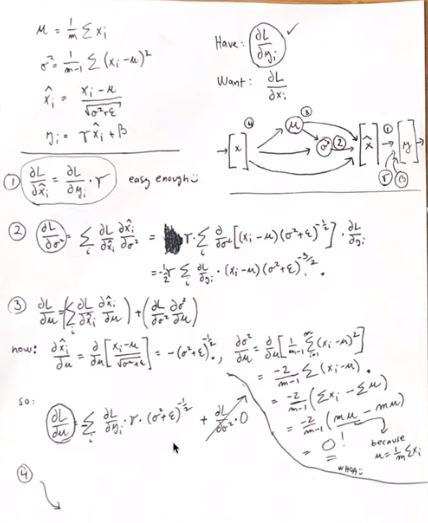

In [451]:
x = Image(filename=r"C:\Users\welcome\Desktop\AndrejKarpathy\bn.JPG")
display(x)

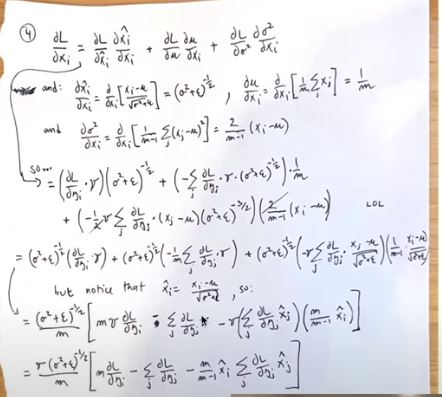

In [452]:
x = Image(filename=r"C:\Users\welcome\Desktop\AndrejKarpathy\bn1.JPG")
display(x)

In [ ]:
#now:
#hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hpbren.var(0, keepdim=True, unbiased))

In [453]:
dhprebn = bngain*bnvar_inv/n * (n * dhpreact.sum(0) -  n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))

In [454]:
cmp('hprebn', dhprebn, hprebn)

hprebn          | exact: False | approximate: False | maxdiff: 0.05224885046482086


In [459]:
#Exercise 4: Pulling it all together
# Train the MLP neural net with your own backward pass

# init
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

# same optimization as last time
max_steps = 200000
batch_size = 32
n = batch_size # convenience
lossi = []

# use this context manager for efficiency once your backward pass is written (TODO)
with torch.no_grad():

  # kick off optimization
  for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer
    hprebn = embcat @ W1 + b1 # hidden layer pre-activation
    # BatchNorm layer
    # -------------------------------------------------------------
    bnmean = hprebn.mean(0, keepdim=True)
    bnvar = hprebn.var(0, keepdim=True, unbiased=True)
    bnvar_inv = (bnvar + 1e-5)**-0.5
    bnraw = (hprebn - bnmean) * bnvar_inv
    hpreact = bngain * bnraw + bnbias
    # -------------------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    #loss.backward() # use this for correctness comparisons, delete it later!

    # manual backprop! #swole_doge_meme
    # -----------------
    dlogits = F.softmax(logits, 1)
    dlogits[range(n), Yb] -= 1
    dlogits /= n
    # 2nd layer backprop
    dh = dlogits @ W2.T
    dW2 = h.T @ dlogits
    db2 = dlogits.sum(0)
    # tanh
    dhpreact = (1.0 - h**2) * dh
    # batchnorm backprop
    dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
    dbnbias = dhpreact.sum(0, keepdim=True)
    dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))
    # 1st layer
    dembcat = dhprebn @ W1.T
    dW1 = embcat.T @ dhprebn
    db1 = dhprebn.sum(0)
    # embedding
    demb = dembcat.view(emb.shape)
    dC = torch.zeros_like(C)
    for k in range(Xb.shape[0]):
        for j in range(Xb.shape[1]):
            ix = Xb[k,j]
            dC[ix] += demb[k,j]
    grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
    # -----------------

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p, grad in zip(parameters, grads):
      #p.data += -lr * p.grad # old way of cheems doge (using PyTorch grad from .backward())
      p.data += -lr * grad # new way of swole doge TODO: enable

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    #if i >= 100: # TODO: delete early breaking when you're ready to train the full net
    #    break

12297
      0/ 200000: 3.8104
  10000/ 200000: 2.1982
  20000/ 200000: 2.4220
  30000/ 200000: 2.4678
  40000/ 200000: 1.9518
  50000/ 200000: 2.4469
  60000/ 200000: 2.4178
  70000/ 200000: 2.0945
  80000/ 200000: 2.3269
  90000/ 200000: 2.2289
 100000/ 200000: 2.0391
 110000/ 200000: 2.3637
 120000/ 200000: 1.9746
 130000/ 200000: 2.4224
 140000/ 200000: 2.4071
 150000/ 200000: 2.1481
 160000/ 200000: 1.9892
 170000/ 200000: 1.8015
 180000/ 200000: 1.9750
 190000/ 200000: 1.8547


In [456]:
# useful for checking your gradients
for p,g in zip(parameters, grads):
    cmp(str(tuple(p.shape)), g, p)

TypeError: all(): argument 'input' (position 1) must be Tensor, not bool

In [460]:
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnvar = hpreact.var(0, keepdim=True, unbiased=True)

In [461]:
# evaluate train and val loss

@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0724594593048096
val 2.1136343479156494


In [462]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20): 
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # ------------
      # forward pass:
      # Embedding
        emb = C[torch.tensor([context])] # (1,block_size,d)      
        embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
        hpreact = embcat @ W1 + b1
        hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
        h = torch.tanh(hpreact) # (N, n_hidden)
        logits = h @ W2 + b2 # (N, vocab_size)
      # ------------
      # Sample
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))

mona.
mayah.
see.
mad.
rylla.
emmastendraegan.
chedielin.
shi.
jenleigh.
estana.
sephukwolter.
noshubergihiriel.
kindreelynn.
novana.
uba.
gedi.
jamyleyeks.
kayshayan.
daihaan.
alynn.


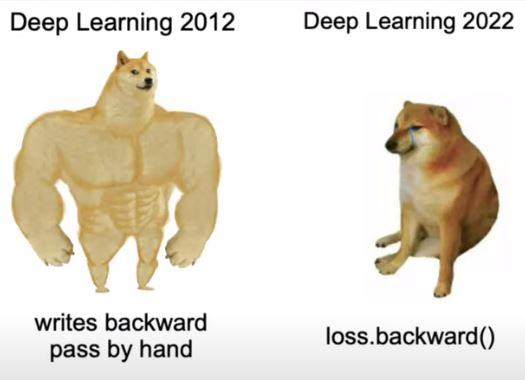

In [463]:
x = Image(filename=r"C:\Users\welcome\Desktop\AndrejKarpathy\final.JPG")
display(x)